In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sys
import random

In [53]:
digits = load_digits()
X = digits.data
y = digits.target.reshape(-1, 1)

print(f"X:\n {X}")
print(f"y:\n {y}")

X:
 [[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
y:
 [[0]
 [1]
 [2]
 ...
 [8]
 [9]
 [8]]


In [54]:
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y)
y_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [55]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

In [56]:
def visualize_sample_digits(X, y, title):
    plt.figure(figsize=(10, 4))
    plt.suptitle(title, fontsize=16)
    indices = random.sample(range(len(X)), 10) # 10 samples
    for i, index in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[index].reshape(8, 8), cmap='gray')
        plt.title(f"Label: {np.argmax(y[index])}")
        plt.axis('off')
    plt.show()

def visualize_predictions(model, X_test, y_test):
    plt.figure(figsize=(12, 8))
    plt.suptitle("Model Predictions on Test Data", fontsize=16)

    logits = model.predict(X_test)
    predictions = np.argmax(logits, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    indices = random.sample(range(len(X_test)), 15) # 15 tests

    for i, index in enumerate(indices):
        plt.subplot(3, 5, i + 1)
        plt.imshow(X_test[index].reshape(8, 8), cmap='gray')

        pred_label = predictions[index]
        true_label = true_labels[index]

        if pred_label == true_label:
            color = "green"
        else:
            color = "red"

        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

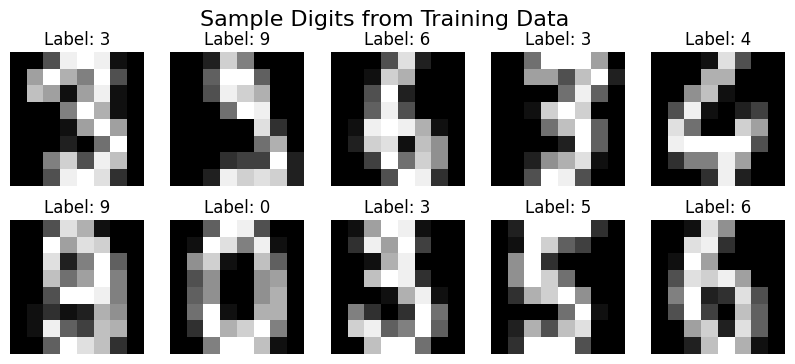

In [57]:
visualize_sample_digits(X_train_raw, y_train, "Sample Digits from Training Data")

In [60]:
# Normalization
X_train = X_train_raw / 16.0
X_test = X_test_raw / 16.0

n_features = X.shape[1]
n_classes = y_one_hot.shape[1]
n_samples = X.shape[0]
print(f"{n_features} features -> {n_classes} classes. {n_samples} samples")

64 features -> 10 classes. 1797 samples


In [59]:
class Layer:
  def forward(self, input):
    pass

  def backward(self, gradient_wrt_loss):
    pass

  def params(self):
    return []

class Linear(Layer):
  def __init__(self, n_input, n_output):
      self.w = np.random.randn(n_output, n_input)
      self.b = np.zeros((1, n_output))
      self.dw = np.zeros_like(self.w)
      self.db = np.zeros_like(self.b)
      self.input = None

  def forward(self, input):
    self.input = input
    return np.dot(input, self.w.T) + self.b

  def backward(self, gradient_wrt_loss):
    self.dw += np.dot(gradient_wrt_loss.T, self.input)
    self.db += np.sum(gradient_wrt_loss, axis=0, keepdims=True)
    return np.dot(gradient_wrt_loss, self.w)

  def params(self):
    return [self.w, self.b]

class ReLU(Layer):
  def __init__(self):
    self.input = None

  def forward(self, input):
    self.input = input
    return np.maximum(0, input)

  def backward(self, gradient_wrt_loss):
    relu_gradient = self.input > 0
    return gradient_wrt_loss * relu_gradient

class Sequential:
  def __init__(self, layers=None):
    if layers == None:
      self.layers = []
    else:
      self.layers = layers

  def add(self, layer):
    self.layers.append(layer)

  def compile(self, optimizer, loss):
    self.optimizer = optimizer
    self.loss = loss

  def forward(self, input):
    output = input
    for layer in self.layers:
        output = layer.forward(output)
    return output

  def backward(self, gradient_wrt_loss):
      for layer in reversed(self.layers):
          gradient_wrt_loss = layer.backward(gradient_wrt_loss)

  def fit(self, X, y, epochs, batch_size=32):
    n_samples = X.shape[0]
    print(f"Training for {epochs} epochs:")
    for epoch in range(epochs):
      epoch_loss = 0
      for i in range(0, n_samples, batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        y_pred = self.forward(X_batch)
        epoch_loss += self.loss(y_pred, y_batch)
        loss_grad = self.loss.gradient(y_pred, y_batch)
        self.backward(loss_grad)
        self.optimizer.step(self.layers)

      if epoch % 100 == 0 or epoch == epochs - 1:
        avg_loss = epoch_loss / (n_samples / batch_size)
        sys.stdout.write(f"\rEpoch {epoch}/{epochs}, Loss: {avg_loss:.6f}")
        sys.stdout.flush()
    print("\nTraining Complete.")

  def evaluate(self, X, y):
    y_pred = self.forward(X)
    loss = self.loss(y_pred, y)
    predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == true_labels)
    return loss, accuracy

  def predict(self, X):
    return self.forward(X)

class CrossEntropyLoss:
    def softmax(self, logits):
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def __call__(self, logits, y_true):
        probas = self.softmax(logits)
        probas = np.clip(probas, 1e-10, 1.0)
        num_samples = logits.shape[0]
        return -np.sum(y_true * np.log(probas)) / num_samples

    def gradient(self, logits, y_true):
        probas = self.softmax(logits)
        num_samples = y_true.shape[0]
        return (probas - y_true) / num_samples

class SGD:
    def __init__(self, learning_rate=0.01):
        self.lr = learning_rate

    def step(self, layers):
        for layer in layers:
            if isinstance(layer, Linear):
                layer.w -= self.lr * layer.dw
                layer.b -= self.lr * layer.db
                layer.dw.fill(0)
                layer.db.fill(0)

Training for 1500 epochs:
Epoch 1499/1500, Loss: 0.031030
Training Complete.

Accuracy on Test Data: 93.89% (Loss: 0.5915)


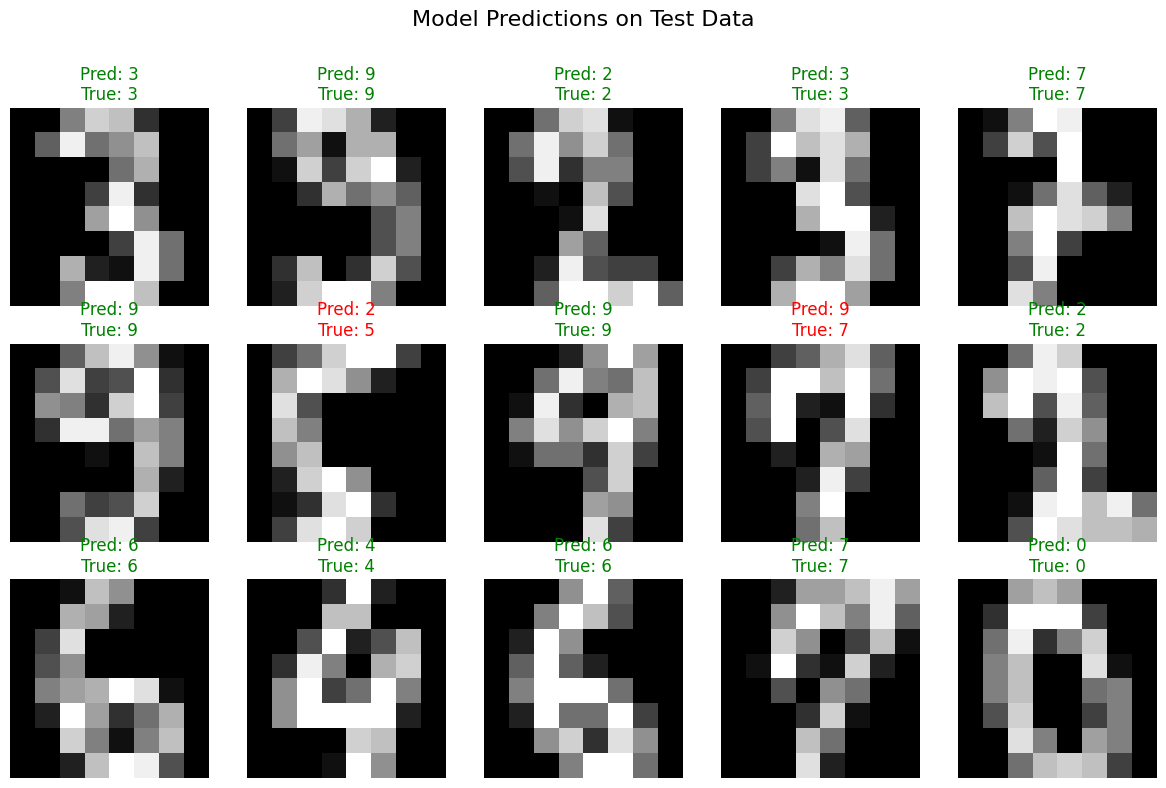

In [51]:
model = Sequential([
    Linear(n_features, 64),
    ReLU(),
    Linear(64, 32),
    ReLU(),
    Linear(32, n_classes)
])

model.compile(optimizer=SGD(learning_rate=0.05), loss=CrossEntropyLoss())

model.fit(X_train, y_train, epochs=1500, batch_size=128)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nAccuracy on Test Data: {test_accuracy * 100:.2f}% (Loss: {test_loss:.4f})")

visualize_predictions(model, X_test, y_test)